# [논문 읽기] Exploring the structure of a real-time, arbitrary neural artistic stylization network

https://arxiv.org/pdf/1705.06830.pdf 

image block

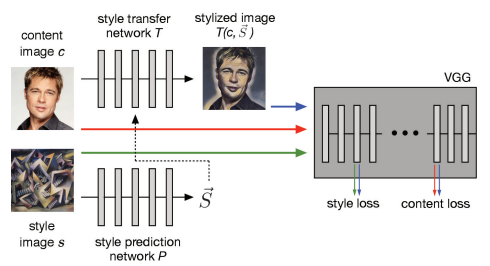

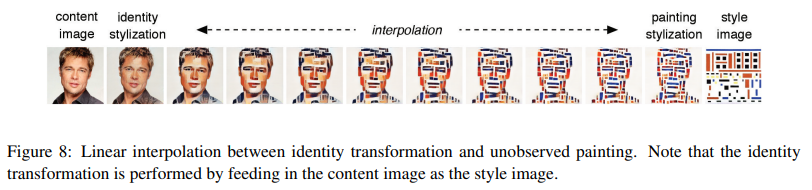

### Introduction
style transfer network를 위해 정규화된 상수의 집합인 input style image로부터, style prediction network P는 embedding vector S를 예측한다

style transfer network는 photograph를 스타일이 입혀 재해석된 이미지로 변형시킨다.


content와 style의 loss는 VGG image classification network에서 계산된다.
- style loss : style이 덧붙여진 image와  style 이미지 사이 오차/거리 
- content loss : style이 덧붙여진 image와 content 이미지 사이 오차/거리

각 거리를 최소화하는 방식으로 작동한다. 그래서 content 내용을 읽지 않으면서 스타일을 학습할 수 있게 된다.

아래 그림은 모델 아키텍쳐가 제공한 embedding space를 저차원에서 나타낸 구조. 오른쪽 빨간 상자 구역은 Monet 그림을 의미한다.  zoom in 해보세요. 주어진 예술가의 예술적 범위와 어휘를 포착하는 저차원 공간이 생성됨.

사용자가 임의로 예술적 스타일화의 강도를 걸 수 있는 보간법도 소개함

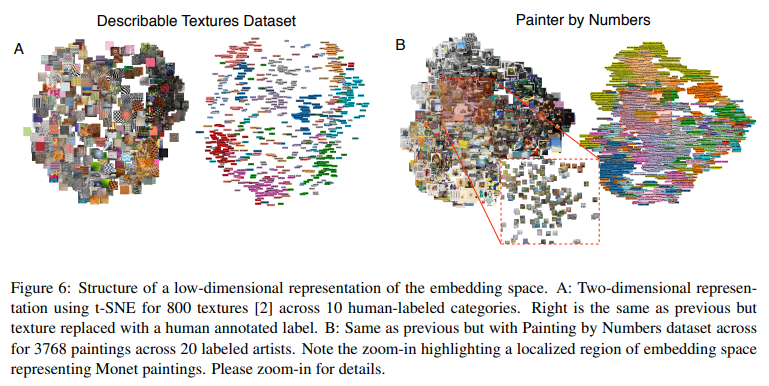

### Methods
artistic style transfer는 content image c와 style image s로부터 style이 덧붙여진 image x를 생성하는 것

보통 c로는 사진작가의 사진을, s로는 그림을 사용한다.

- 두 이미지의 **content**가 유사하다 = high-level features(**추상적인 특징**)의 거리가 가깝다 (**유클리디언 거리** - 숫자를 공간 상에서 나타냈을 때의 두 지점의 거리를 의미)
    - 이미지에 content가 담길, 의미 있는 추상화된 정보들은 high-level feature 에서 얻도록 학습되기에
- 두 이미지의 **style**이 유사하다 = low-level features(**질감**같은 세세한 특징)가 **통계학적으로 그렸을 때 같은 공간을 공유한다.**
    - style이 질감이라는 가정 하에, 질감이 유사하다는 것은 저차원 공간 상에서 **Gram Matrix에 의해** 표현되는 정보가 유사하다는 의미

## Further Research
secondary embedding loss를 개선하기 위해 그림의 metadata를 활용하거나, 원본 사진의 색을 보존하는 방법으로 시각적 품질 향상시키기 등이 있다.

이 방식은 이미지로 제한되어있기에 실시간 비디오에서는, loss function을 추가하여 frame 간 시각적 일관성을 강화하도록 모델을 훈련시킬 수 있다.


# ⚙️ Setup

In [ ]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# GPU로 설정하였을 때
# GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 🖼️ 이미지 불러오고 시각화하기

### 함수 정의 : Image 가져오기

In [ ]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

In [ ]:
@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

### 함수 정의 : 시각화

In [ ]:
def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

### 실행

여기에서 사용된 이미지의 출처 : https://commons.wikimedia.org/wiki/Main_Page

In [ ]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

In [ ]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'
output_image_size = 384  

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

# 🔥 Import TF Hub module

In [ ]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# 😲 Demonstrate image stylization

In [ ]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# content_image, style_image, and stylized_image가 
# 4-D Tensors with shapes [batch_size, image_height, image_width, 3]로 예상된다면

# 현재 예제에서는 단일 이미지만 제공하므로 batch_size=1 (여러 이미지를 한다면 여기를 키우기)
# 또한 이미지들의 입력과 출력 값의 범위는 0~1이어야 함

# content와 style의 shape가 같지 않아도 된다.
# output image shape는 content image size를 따라간다.

In [ ]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [ ]:

content_urls = dict(
  sea_turtle='https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
  tuebingen='https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg',
  grace_hopper='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
  )
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}


In [ ]:
content_name = 'sea_turtle'  
style_name = 'munch_scream'  

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

In [ ]:
content_name = 'tuebingen'  
style_name = 'munch_scream'  

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

In [ ]:
content_name = 'grace_hopper'  
style_name = 'hubble_pillars_of_creation'  

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])

In [ ]:
content_name = 'tuebingen'  
style_name = 'kandinsky_composition_7'  

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])